<a href="https://colab.research.google.com/github/tranngocsongtruc/hw2-resnet/blob/main/Copy_of_%5BFall_2023%5D_HW2_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2: Resnet

Credit: Sohom Paul, Saathvik Selvan, Aryan Jain

In lecture you've seen a history of neural network architectures. In this notebook, we will be implementing one of the most important CNN architectures of the past few years - the ResNet.

For further refernce on ResNet, you can refer to the [original paper](https://arxiv.org/pdf/1512.03385.pdf) or you can read this [fantastic blog post](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8) on the subject.

In [ ]:
import time
import os

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torchvision import transforms as T
from torchvision import models, datasets

from tqdm.notebook import tqdm

import numpy as np
from matplotlib import pyplot as plt
from random import randint

### Part 1: Loading the Data

Recall that `torchvision` gives us direct access to common datasets, which saves us from downloading the data ourselves and writing a custom `DataLoader`. This is really handy for when you're doing some quick prototyping or doing research. We will be using the classic CIFAR-10 dataset. This function may take a few seconds to run because it needs to download the dataset from the internet.

In [ ]:
batch_size = 32
data_root = './data/cifar10'
transform = T.Compose([
    T.ToTensor(),
    # scales pixel values to range [-1, 1]
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_size = 40_000
val_size = 10_000

In [ ]:
dataset = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform,
)
assert train_size + val_size <= len(dataset), "Trying to sample too many elements!" \
    "Please lower the train or validation set sizes."
train_set, val_set, _ = torch.utils.data.random_split(
    dataset, [train_size, val_size, len(dataset) - train_size - val_size]
)
classes = (
    'plane', 'car', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck',
)

100%|██████████| 170498071/170498071 [00:01<00:00, 100248917.56it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

showing training images


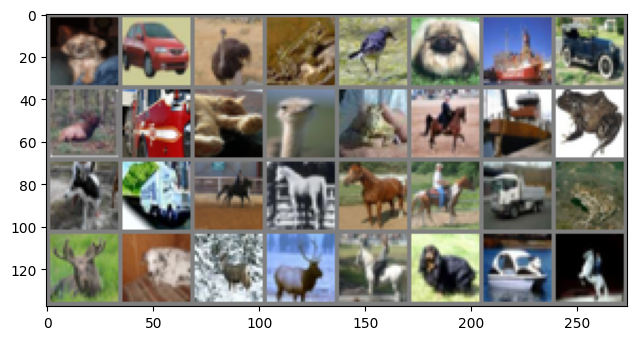


... and their corresponding labels
dog      car      bird     frog     bird     dog      ship     car     
deer     truck    cat      bird     frog     horse    ship     frog    
dog      truck    horse    horse    horse    horse    truck    frog    
deer     dog      deer     deer     horse    dog      ship     horse   


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [7.5, 7.5]

def show_image(img):
    img = img / 2 + 0.5
    img = img.numpy()
    img = img.transpose([1, 2, 0])
    plt.imshow(img)
    plt.show()

images, labels = next(iter(train_loader))
nrow = 4
print('showing training images')
show_image(torchvision.utils.make_grid(images, nrow=batch_size // nrow))
print('\n... and their corresponding labels')
for idxs in np.array_split(np.arange(batch_size), nrow):
    print(' '.join(f'{classes[labels[j]]:8s}' for j in idxs))

### Part 2: Fully Connected Neural Network

The most basic neural network structure is a fully-connected neural network. This means that every neuron in each layer is connected to every neuron in the previous layer. Let's try implementing one.

In [ ]:
class FCNN(nn.Module):
    def __init__(self, layer_dims):
        '''
        Initialize the torch.nn.Module and define some layers for future ues
        layer_dims: list of integers, representing the width
            of each of the layers of our NN. For simplicity, you may assume
            that len(layer_dims) == 3
        '''
        ## YOUR CODE HERE
        ## TODO: Remember your call to super!
        ## TODO: Create some linear layers you can use in foward
        ## You may either hard-code that there will be 3 layers,
        ## or you can look into torch.nn.ModuleList()
        ## END YOUR CODE
        super(FCNN, self).__init__()
        self.layer_dims = layer_dims

        # Create the linear layers
        self.fc1 = nn.Linear(layer_dims[0], layer_dims[1])
        self.fc2 = nn.Linear(layer_dims[1], layer_dims[2])

    def forward(self, x):
        '''
        Compute a forward pass of your batch of images

        x: torch.Tensor of shape (batch_size, num_channels, width, height)
        returns: result of passing x through your network
        '''
        ## YOUR CODE HERE
        ## TODO: Flatten the images; remeber that x has a whole batch!
        ## TODO: Apply each of the layers and relu after each one
        ## END YOUR CODE
        # Flatten the input
        x = x.view(x.size(0), -1)  # Reshape (flatten) the input

        # Apply each of the layers and ReLU activation after each one
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        return x

Here you will get a chance to implement parts of our training and validation loops. If you find yourself struggling, take a look at the training loop from the first homework -- these loops are usually pretty standard and have many similarities regardless of the model.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def compute_accuracy(model, loader):
    total_correct = 0

    ## YOUR CODE HERE
    ## TODO: Put the model on our device (may not always be CPU)
    ## TODO: Enable eval mode on the model
    ## END YOUR CODE
    # Put the model on our device (may not always be CPU)
    model.to(device)

    # Enable eval mode on the model
    model.eval()

    for inputs, labels in tqdm(loader, leave=False):
        ## YOUR CODE HERE
        ## TODO: Put the inputs and labels on our device
        ## TODO: Compute the model outputs
        ## TODO: Calculate the number of correct predictions (hint: use torch.argmax)
        ## TODO: Update the total number of correct predictions
        ## END YOUR CODE
        # Put the inputs and labels on our device
        inputs, labels = inputs.to(device), labels.to(device)

        # Compute the model outputs
        outputs = model(inputs)

        # Calculate the number of correct predictions (hint: use torch.argmax)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
    return total_correct / len(loader.dataset)

def train(model, train_loader, val_loader, num_epochs, criterion, optimizer, path = None, scheduler = None):
    print('beginning to train model')
    if path and not os.path.exists(path):
      os.makedirs(path)

    ## YOUR CODE HERE
    ## TODO: Put the model on our device (may not always be CPU)
    ## END YOUR CODE
    # Put the model on our device (may not always be CPU)
    model.to(device)

    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        total_loss = 0
        start_time = time.perf_counter()
        for inputs, labels in tqdm(train_loader, leave=False):
            ## YOUR CODE HERE
            ## TODO: Put the inputs and labels on our device
            ## TODO: Zero out the gradients
            ## TODO: Compute the model outputs
            ## TODO: Calculate the loss
            ## TODO: Backpropagate the loss
            ## TODO: Perform an optimizer step
            ## TODO: Update the total loss with the current loss
            ## END YOUR CODE
            # Put the inputs and labels on our device
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero out the gradients
            optimizer.zero_grad()

            # Compute the model outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagate the loss
            loss.backward()

            # Perform an optimizer step
            optimizer.step()

            # Update the total loss with the current loss
            total_loss += loss.item()

        if path:
          torch.save(model.state_dict(), f'{path}/model_ep_{epoch:02d}.pth')
        end_time = time.perf_counter()
        duration = end_time - start_time

        ## YOUR CODE HERE
        ## TODO: Compute the training and validation accuracies (hint: use compute_accuracy())
        ## END YOUR CODE
        # Compute the training and validation accuracies (hint: use compute_accuracy())
        train_acc = compute_accuracy(model, train_loader)
        val_acc = compute_accuracy(model, val_loader)

        current_lr = optimizer.param_groups[0]['lr']

        if scheduler and current_lr > 5e-5:
            scheduler.step()

        print(f'epoch {epoch:2}',
              f'loss: {total_loss:.3f}',
              f'time: {duration:.3f}',
              f'train acc: {train_acc:.4f}',
              f'val acc: {val_acc:.4f}', sep='\t')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
num_epochs = 15
layer_dims = [3072, 100, 10]
fcnn = FCNN(layer_dims)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(fcnn.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
train(fcnn, train_loader, val_loader, num_epochs, criterion, optimizer)

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 2415.198	time: 17.125	train acc: 0.4032	val acc: 0.3930


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 2084.064	time: 14.366	train acc: 0.4550	val acc: 0.4355


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 1946.410	time: 14.019	train acc: 0.4800	val acc: 0.4590


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 1869.575	time: 14.523	train acc: 0.5027	val acc: 0.4735


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 1807.987	time: 14.330	train acc: 0.5187	val acc: 0.4801


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 1757.530	time: 13.973	train acc: 0.5329	val acc: 0.4932


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 1708.235	time: 14.605	train acc: 0.5460	val acc: 0.4964


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 1665.933	time: 14.611	train acc: 0.5576	val acc: 0.4979


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 1630.552	time: 14.615	train acc: 0.5685	val acc: 0.5070


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 1592.969	time: 14.136	train acc: 0.5769	val acc: 0.5035


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 1561.023	time: 14.795	train acc: 0.5866	val acc: 0.5097


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 1529.045	time: 14.564	train acc: 0.5939	val acc: 0.5091


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 1500.087	time: 14.559	train acc: 0.6011	val acc: 0.5076


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 1473.841	time: 15.484	train acc: 0.6096	val acc: 0.5064


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 1450.518	time: 14.779	train acc: 0.6178	val acc: 0.5129


As a final observation, let's print the number of parameters that this network learned.

In [ ]:
print(count_parameters(fcnn))

308310


### Part 3: Basic Convolutional Neural Network

You've likely seen in the above example that the validation accuracy of the fully-connected network was not terrible (definitely above the 10% accuracy we'd get from random guessing!), but not too great either.

There are two main issues with fully-connected neural networks. The first is scalability. Because every neuron in each layer is connected to every neuron in the next layer, the number of weights we have in each layer is the product of the sizes of the hidden layers. This means that in order to keep the number of parameters for our model reasonable, we need to either restrict the number of layers or decrease the size of the hidden layers. This prevents us from making very deep fully connected networks that can learn very interesting patterns.

The second issue is that fully connected neural networks are prone to overfitting because they will learn different patterns for each possible pixel in the input image - shifting over the subject of the image by 1 pixel could totally change the output of the network!

These two issues led to the development of the convolutional neural network. The fundamental idea is that instead of connecting all the neurons together, the model instead learns a series of convolutional _kernels_ that it can slide across the image. These kernels make it so that we're applying the same operations to different parts of the image, reducing overfitting, and greatly reduces the number of weights we need, which can improve training time and allow us to train deeper networks.

For more on how CNNs work, check out [this blog post](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53) and the lecture slides posted on the course website!

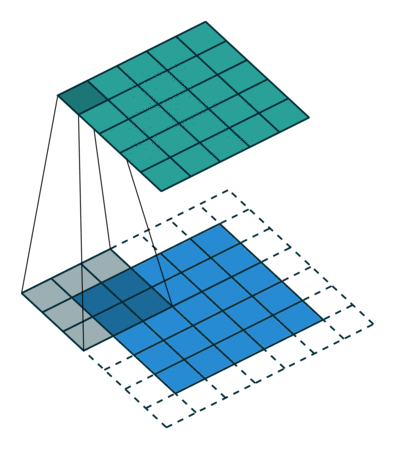

Above: Example convolutional filter. Image courtesy of [Sumit Saha](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53).

Now we implement a basic convolutional neural network.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        '''
        Initialize the torch.nn.Module and define some layers for future ues.

        Please use the following network structure:
        - conv layer with 5 output channels and kernel size 5
        - max pooling on 2 by 2 blocks with stride of 2
        - conv layer with 16 output channels and kernel size 5
        - max pooling on 2 by 2 blocks with stride of 2
        - linear (fully-connected) layer with 120 output dims
        - linear (fully-connected) layer with 84 output dims
        - linear (fully-connected) layer with 10 output dims

        After any convolutional or linear layer EXCEPT for the final output,
        we will use a relu activation.
        '''
        ## YOUR CODE HERE
        ## TODO: Define your layers
        ## END YOUR CODE
        super(CNN, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=16, kernel_size=5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define the fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        '''
        Compute a forward pass of your batch of images. Refer to the docstring
        for the init method for the order in which to call

        x: torch.Tensor of shape (batch_size, num_channels, width, height)
        returns: result of passing x through your network
        '''
        ## YOUR CODE HERE
        ## TODO: Call your convolutional layers, with activation and pooling.
        ## TODO: Flatten your output
        ## TODO: Call your linear layers, with activation.
        ## TODO: Remember NOT to call activation after final fully connected layer!
        ## END YOUR CODE
        # Call your convolutional layers, with activation and pooling
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)

        # Flatten your output
        x = x.view(x.size(0), -1)

        # Call your linear layers, with activation
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        # Remember NOT to call activation after the final fully connected layer
        x = self.fc3(x)

        return x

In [ ]:
num_epochs = 15
cnn = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
train(cnn, train_loader, val_loader, num_epochs, criterion, optimizer)

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 2817.407	time: 20.314	train acc: 0.2362	val acc: 0.2383


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 2406.502	time: 15.428	train acc: 0.3604	val acc: 0.3527


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 2077.441	time: 15.512	train acc: 0.4264	val acc: 0.4149


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 1921.824	time: 15.576	train acc: 0.4613	val acc: 0.4513


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 1820.723	time: 15.292	train acc: 0.4815	val acc: 0.4701


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 1738.002	time: 15.661	train acc: 0.5072	val acc: 0.4887


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 1664.369	time: 15.180	train acc: 0.5402	val acc: 0.5168


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 1600.483	time: 16.634	train acc: 0.5603	val acc: 0.5386


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 1533.526	time: 14.987	train acc: 0.5747	val acc: 0.5537


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 1485.938	time: 16.392	train acc: 0.5927	val acc: 0.5577


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 1441.656	time: 15.637	train acc: 0.6043	val acc: 0.5655


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 1399.870	time: 15.429	train acc: 0.6102	val acc: 0.5643


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 1352.702	time: 15.630	train acc: 0.6361	val acc: 0.5897


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 1324.759	time: 15.512	train acc: 0.6376	val acc: 0.5821


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 1289.243	time: 16.630	train acc: 0.6567	val acc: 0.5974


In [ ]:
fcnn_num_params = count_parameters(fcnn)
cnn_num_params = count_parameters(cnn)
print('FCNN Num Params:', fcnn_num_params)
print('CNN Num Params:', cnn_num_params)
print('Ratio:', cnn_num_params/fcnn_num_params)

FCNN Num Params: 308310
CNN Num Params: 61530
Ratio: 0.19957185949206968


So we've improved validation accuracy while using 80% fewer parameters. Nice!

### Part 4: Using ResNet for Classification

The network that we're implementing here is here is the residual network (ResNet), a CNN variant and one of the most important networks in modern computer vision.

The fundamental idea behind ResNet is the _skip connection_. In very deep neural networks, we frequently run into the _vanishing gradient problem_, where updates during backpropagation can be multiplied by very small numbers and result in the first few layers of the network learning very slowly. Skip connections rectify this problem by having outputs of some layers jump ahead and skip a few layers and get added in later on. This means that gradient updates have to travel back a shorter distance to update the earlier layers in the network.

The reason that it's called a residual network is because our residual blocks, instead of learning the function $f(x)$, instead learn the _residual_ $f(x) - x$. The input $x$ gets added back in using the skip connection.

For more details, try checking out the [original ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) or [this fantastic blog post](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8).

Because this is a fairly involved architecture, we will only ask you to implement a single residual block of a ResNet18 model.

In [ ]:
class ResNetBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        '''
        Create a residual block for our ResNet18 architecture.

        Here is the expected network structure:
        - conv layer with
            out_channels=out_channels, 3x3 kernel, stride=stride
        - batchnorm layer
        - conv layer with
            out_channels=out_channels, 3x3 kernel, stride=1
        - batchnorm layer
        - shortcut layer:
            if either the stride is not 1 or the out_channels is not equal to in_channels:
                the shortcut layer is composed of two steps:
                - conv layer with
                    in_channels=in_channels, out_channels=out_channels, 3x3 kernel, stride=stride
                - batchnorm layer
            else:
                the shortcut layer should be an no-op

        All conv layers will have a padding of 1 and no bias term. To facilitate this, consider using
        the provided conv() helper function.
        When performing a forward pass, the ReLU activation should be applied after the first batchnorm layer
        and after the second batchnorm gets added to the shortcut.
        '''
        ## YOUR CODE HERE
        ## TODO: Initialize the block with a call to super and make your conv and batchnorm layers.
        ## TODO: Use some conditional logic when defining your shortcut layer
        ## For a no-op layer, consider creating an empty nn.Sequential()
        ## END YOUR CODE
        super(ResNetBlock, self).__init__()

        # Define the convolutional layers with batch normalization
        self.conv1 = self.conv(in_channels, out_channels, 3, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = self.conv(out_channels, out_channels, 3, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Define the shortcut connection (identity or additional convolution)
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                self.conv(in_channels, out_channels, 3, stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Sequential()

    def conv(self, in_channels, out_channels, kernel_size, stride):
        return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1, bias=False)

    def forward(self, x):
        '''
        Compute a forward pass of this batch of data on this residual block.

        x: batch of images of shape (batch_size, num_channels, width, height)
        returns: result of passing x through this block
        '''
        ## YOUR CODE HERE
        ## TODO: Call the first convolution, batchnorm, and activation
        ## TODO: Call the second convolution and batchnorm
        ## TODO: Also call the shortcut layer on the original input
        ## TODO: Sum the result of the shortcut and the result of the second batchnorm
        ## and apply your activation
        ## END YOUR CODE
        # Apply the first convolution, batch normalization, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))

        # Apply the second convolution and batch normalization
        out = self.bn2(self.conv2(out))

        # Apply the shortcut connection and add it to the main path
        out += self.shortcut(x)

        # Apply the final ReLU activation
        out = F.relu(out)

        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=64,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.in_channels = 64
        self.layer1 = self.make_block(out_channels=64, stride=1, rep=2)
        self.layer2 = self.make_block(out_channels=128, stride=2, rep=2)
        self.layer3 = self.make_block(out_channels=256, stride=2, rep=2)
        self.layer4 = self.make_block(out_channels=512, stride=2, rep=2)
        self.linear = nn.Linear(512, num_classes)

    def make_block(self, out_channels, stride, rep):
        layers = []
        for stride in [stride, 1]:
            layers.append(ResNetBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = F.avg_pool2d(x, 4)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return x

In [ ]:
num_epochs = 15
resnet = ResNet18(num_classes = 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=1e-3, momentum=0.9)

Now that we have defined our model, feel free to use this `torchsummary` package function to visualize how an image is passed through the network and how the layers change the shape of the image. The final convolution layer should output a tensor of size `(32, 512, 4, 4)`, which is averaged, flattened, and passed through a fully connected layer to end up with a `(32, 10)` tensor of classification scores. To evaluate predictions, we simply take the `argmax` of our output.



In [ ]:
resnet = resnet.to(device)
summary(resnet, input_size = (3, 32, 32), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 32, 32]           1,728
       BatchNorm2d-2           [32, 64, 32, 32]             128
            Conv2d-3           [32, 64, 32, 32]          36,864
       BatchNorm2d-4           [32, 64, 32, 32]             128
            Conv2d-5           [32, 64, 32, 32]          36,864
       BatchNorm2d-6           [32, 64, 32, 32]             128
       ResNetBlock-7           [32, 64, 32, 32]               0
            Conv2d-8           [32, 64, 32, 32]          36,864
       BatchNorm2d-9           [32, 64, 32, 32]             128
           Conv2d-10           [32, 64, 32, 32]          36,864
      BatchNorm2d-11           [32, 64, 32, 32]             128
      ResNetBlock-12           [32, 64, 32, 32]               0
           Conv2d-13          [32, 128, 16, 16]          73,728
      BatchNorm2d-14          [32, 128,

This model will take about 20 minutes to train. Make sure that you are connected to a GPU runtime for Colab or, if you have GPU on your computer, consider training locally. Watch out for Colab's runtime disconnecting; it shouldn't be a big problem for this homework, but make sure to keep the browser tab open while the models are training.

The staff implementation got a validation accuracy of ~60% after 1 training epoch. If your results are significantly worse than that, consider stopping your training run and debugging your model.

In [ ]:
train(resnet, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_resnet')

beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 1673.733	time: 51.425	train acc: 0.6480	val acc: 0.6182


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 1050.311	time: 52.173	train acc: 0.7422	val acc: 0.6728


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 752.411	time: 51.798	train acc: 0.8499	val acc: 0.7436


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 528.283	time: 52.330	train acc: 0.9088	val acc: 0.7568


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 344.095	time: 52.107	train acc: 0.9465	val acc: 0.7689


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 219.670	time: 52.053	train acc: 0.9631	val acc: 0.7618


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 143.612	time: 52.236	train acc: 0.9613	val acc: 0.7538


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 110.419	time: 52.397	train acc: 0.9882	val acc: 0.7818


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 68.766	time: 52.396	train acc: 0.9936	val acc: 0.7857


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 40.355	time: 53.121	train acc: 0.9973	val acc: 0.7954


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 31.579	time: 52.657	train acc: 0.9973	val acc: 0.7887


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 18.001	time: 52.563	train acc: 0.9981	val acc: 0.7951


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 15.341	time: 52.659	train acc: 0.9997	val acc: 0.8025


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 8.596	time: 52.453	train acc: 0.9999	val acc: 0.8047


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 5.585	time: 52.266	train acc: 0.9999	val acc: 0.8080


And there we have it! Just by adding these skip connections, we dramatically improved the classification accuracy compared to a vanilla CNN!

### Part 5: Optimizing Hyperparameters and Other Tricks

In this section, you will be trying to achieve a **validation accuracy** of **at least 90%** on the same CIFAR-10 Dataset. Below, we have provided code to allow you to change various properties of your model, training procedure, and dataset augmentation. You are allowed to use whatever you wish except loading in pretrained models. However, creating your own model architecture below using any of the tricks we have learnt in class is fair game.

Here are a couple ideas to get you started:
- Batch size
- Learning rate
- Optimizer
- Loss function
- Learning rate
- Number of epochs
- Image transform
- Different kinds of layers (dropout, batchnorm, etc.)

In [ ]:
import torch
import torchvision.transforms as T
from torchvision import datasets
import torch.nn as nn
import torch.optim as optim

data_root = './data/cifar10'
train_size = 40000
val_size = 10000

## YOUR CODE HERE
## TODO: Modify the given transforms and hyperparameters
batch_size = 32

# transform_train = T.Compose([
#     T.RandomHorizontalFlip(),
#     T.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.95, 1.05)),
#     T.ToTensor(),
#     T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# ])
transform_train = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(degrees=15),  # Add random rotation with a maximum angle of 15 degrees.
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Add color jitter.
    T.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.8, 1.2)),  # Randomly crop and resize the image.
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transform_val = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
## END YOUR CODE

dataset = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=None,
)

assert train_size + val_size <= len(dataset), "Trying to sample too many elements!" \
    "Please lower the train or validation set sizes."
train_set, val_set, _ = torch.utils.data.random_split(
    dataset, [train_size, val_size, len(dataset) - train_size - val_size]
)

class CustomTransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
      return len(self.subset)

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y

train_set = CustomTransformDataset(train_set, transform=transform_train)
val_set = CustomTransformDataset(val_set, transform=transform_val)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

Files already downloaded and verified


In [ ]:
## YOUR CODE HERE
## TODO: Modify the given hyperparameters
num_epochs = 15
## Feel free to create a bigger resnet model, or use a completely different CNN architecture
## The goal of this problem is for you to apply all of the deep learning tricks we have learnt so far
## to try and maximize the validation accuracy on CIFAR-10 as much as possible.
# final_cnn = ResNet18(num_classes = 10)
final_cnn = torchvision.models.resnet50(pretrained=True)  # Load a pre-trained ResNet-50 model.
final_cnn.fc = nn.Linear(final_cnn.fc.in_features, 10)  # Modify the fully connected layer for 10 classes.

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(final_cnn.parameters(), lr=1e-3, momentum=0.9)
optimizer = optim.SGD(final_cnn.parameters(), lr=0.001, momentum=0.9)  # Decreased learning rate to 0.001.

# TODO: Maybe add a learning rate scheduler?
# Add a learning rate scheduler to adjust learning rate during training.
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decrease learning rate every 5 epochs.


## END YOUR CODE

# train(final_cnn, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_final_cnn', scheduler)
train(final_cnn, train_loader, val_loader, num_epochs, criterion, optimizer, 'checkpoints_final_cnn', scheduler)


beginning to train model


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  1	loss: 1551.391	time: 110.743	train acc: 0.7126	val acc: 0.7517


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  2	loss: 1064.079	time: 82.150	train acc: 0.7777	val acc: 0.8068


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  3	loss: 902.689	time: 80.068	train acc: 0.8027	val acc: 0.8094


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  4	loss: 822.876	time: 79.251	train acc: 0.8227	val acc: 0.8293


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  5	loss: 743.961	time: 80.552	train acc: 0.8308	val acc: 0.8304


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  6	loss: 652.016	time: 81.118	train acc: 0.8601	val acc: 0.8497


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  7	loss: 597.355	time: 78.419	train acc: 0.8685	val acc: 0.8516


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  8	loss: 571.559	time: 77.865	train acc: 0.8742	val acc: 0.8534


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch  9	loss: 552.536	time: 75.700	train acc: 0.8812	val acc: 0.8537


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 10	loss: 528.428	time: 78.100	train acc: 0.8880	val acc: 0.8537


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 11	loss: 479.244	time: 78.524	train acc: 0.8979	val acc: 0.8642


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 12	loss: 462.230	time: 78.626	train acc: 0.9016	val acc: 0.8632


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 13	loss: 445.675	time: 79.161	train acc: 0.9069	val acc: 0.8631


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 14	loss: 437.962	time: 77.715	train acc: 0.9073	val acc: 0.8653


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

epoch 15	loss: 428.883	time: 76.979	train acc: 0.9112	val acc: 0.8638


### Part 6: Autograder and Submission

After you feel confident that you have a decent model, run the cell below.

Feel free to read the code block but **PLEASE DO NOT TOUCH IT**: this will produce a pickle file that will contain your model's predictions on the CIFAR-10 validation set --- tampering with the code block below might mess up the file that you will submit to the Gradescope autograder.

In [ ]:
import pickle

cifar_test = datasets.CIFAR10('.', download = True, train = False, transform = transform_val)
loader_test = DataLoader(cifar_test, batch_size=32, shuffle=False)

final_cnn.eval()  # set model to evaluation mode
predictions = []
with torch.no_grad():
    for x, _ in loader_test:
        x = x.to(device=device)  # move to device, e.g. GPU
        scores = final_cnn(x)
        _, preds = scores.max(1)
        predictions.append(preds)
predictions = torch.cat(predictions).tolist()
with open("my_predictions.pickle", "wb") as file:
    pickle.dump(predictions, file)

100%|██████████| 170498071/170498071 [00:03<00:00, 50059139.70it/s]


Extracting ./cifar-10-python.tar.gz to .
